In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
%matplotlib inline
#plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

In [80]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit, train_test_split, learning_curve,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
rnd_state = 0
plt.style.use('ggplot')

In [5]:
# create a database connection
sqluser = 'maxim'
dbname = 'maxim'
schema_name = 'mimiciii'

In [6]:
# Connect to local postgres version of mimic
connect = psycopg2.connect(dbname=dbname, user=sqluser)
cursor = connect.cursor()
cursor.execute('SET search_path to {}'.format(schema_name))

In [79]:
# Load in the query from file
query='SELECT * FROM OASIS'
oasis = pd.read_sql_query(query, connect)
oasis = oasis.dropna(axis=0)
oasis = oasis.loc[(oasis.urineoutput < 20000) & (oasis.urineoutput > 0) & 
                  (oasis.temp > 30) & (oasis.temp < 45) & (oasis.icustay_age_group == 'adult')]
oasis['preiculos_hours'] = oasis.preiculos.dt.total_seconds()/3600

In [38]:
oasis.head()

,subject_id,hadm_id,icustay_id,icustay_age_group,hospital_expire_flag,icustay_expire_flag,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heartrate_score,meanbp,meanbp_score,resprate,resprate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score,preiculos_hours
0,55973,152234,200001,adult,0,0,42,0.305849,61.0,6,7 days 03:02:12,1,14.0,3.0,134.0,6.0,60.000000,2.0,32.0,6.0,36.388889,2.0,250.0,10.0,0,0,0,6,171.036667
1,27513,163557,200003,adult,0,0,35,0.152892,48.0,3,0 days 02:48:04,3,15.0,0.0,122.0,3.0,179.000000,3.0,39.0,6.0,36.388889,2.0,3652.0,0.0,1,9,0,6,2.801111
2,10950,189514,200006,adult,0,0,32,0.109623,54.0,6,0 days 00:01:14,5,15.0,0.0,73.0,0.0,61.000000,2.0,27.0,1.0,36.166666,2.0,1955.0,1.0,1,9,0,6,0.020556
3,20707,129310,200007,adult,0,0,26,0.054187,43.0,3,0 days 00:01:37,5,15.0,0.0,104.0,1.0,50.666698,3.0,29.0,1.0,36.388889,2.0,1295.0,5.0,0,0,0,6,0.026944
4,29904,129607,200009,adult,0,0,25,0.048012,47.0,3,-1 days +23:49:32,5,15.0,0.0,106.0,1.0,60.000000,2.0,17.5,0.0,34.599998,4.0,1570.0,1.0,1,9,1,0,-0.174444


In [9]:
oasis.describe()

,subject_id,hadm_id,icustay_id,hospital_expire_flag,icustay_expire_flag,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heartrate_score,meanbp,meanbp_score,resprate,resprate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score,preiculos_hours
count,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000,48497.000000
mean,37065.318886,149944.782255,250031.727179,0.115471,0.079613,31.504856,0.147448,74.295647,5.746067,1 days 17:46:56.926840,3.252160,13.763800,1.597068,100.977222,2.017671,69.265614,1.522094,24.676636,2.447966,36.476277,2.711529,1937.439610,3.027383,0.435986,3.923872,0.123492,5.259047,41.782480
std,29114.523921,28900.940921,28922.957312,0.319593,0.270696,8.881217,0.144858,55.128642,2.200174,5 days 18:17:23.808437,1.999852,2.582271,2.519617,24.376383,1.967055,30.938240,1.258332,9.789759,2.645638,1.219447,1.054599,1304.054693,3.314509,0.495890,4.463013,0.329005,1.974028,138.289947
min,3.000000,100001.000000,200001.000000,0.000000,0.000000,4.000000,0.003455,15.000000,0.000000,-2 days +12:14:05,0.000000,3.000000,0.000000,0.350000,0.000000,0.200000,0.000000,0.200000,0.000000,30.222223,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-35.765278
25%,13385.000000,124881.000000,224949.000000,0.000000,0.000000,25.000000,0.048012,52.000000,3.000000,0 days 00:01:18,1.000000,14.000000,0.000000,89.000000,1.000000,51.666698,0.000000,19.000000,1.000000,35.666667,2.000000,1031.000000,1.000000,0.000000,0.000000,0.000000,6.000000,0.021667
50%,26960.000000,149947.000000,250130.000000,0.000000,0.000000,31.000000,0.097783,65.000000,6.000000,0 days 00:02:48,5.000000,15.000000,0.000000,101.000000,1.000000,59.000000,2.000000,26.000000,1.000000,36.111111,2.000000,1690.000000,1.000000,0.000000,0.000000,0.000000,6.000000,0.046667
75%,60739.000000,174997.000000,275113.000000,0.000000,0.000000,37.000000,0.188911,77.000000,6.000000,0 days 21:14:10,5.000000,15.000000,3.000000,116.000000,3.000000,85.500000,3.000000,30.000000,6.000000,37.388891,4.000000,2563.000000,5.000000,1.000000,9.000000,0.000000,6.000000,21.236111
max,99999.000000,199999.000000,299999.000000,1.000000,1.000000,70.000000,0.939936,310.000000,9.000000,169 days 15:25:31,5.000000,15.000000,10.000000,280.000000,6.000000,299.000000,4.000000,69.000000,10.000000,42.777778,6.000000,18347.000000,10.000000,1.000000,9.000000,1.000000,6.000000,4071.425278


In [10]:
oasis.shape

(48497, 29)

In [11]:
oasis.icustay_age_group.value_counts()

adult    48497
Name: icustay_age_group, dtype: int64

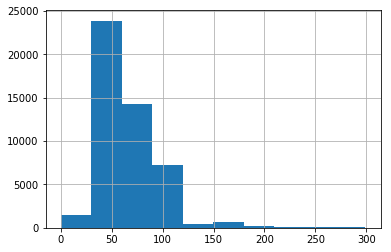

In [12]:
oasis.meanbp.hist()

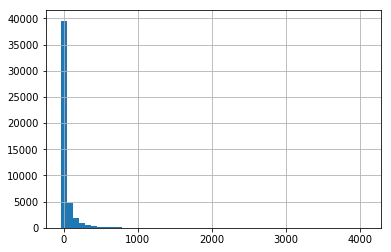

In [13]:
oasis.preiculos_hours.hist(bins=50)

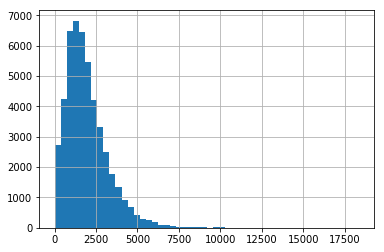

In [14]:
oasis.urineoutput.hist(bins=50)

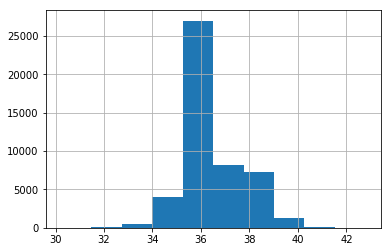

In [15]:
oasis.temp.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20254a90>,
      dtype=object)

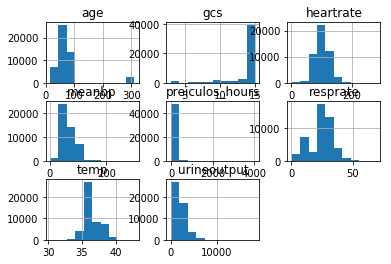

In [16]:
oasis[['age', 'preiculos_hours', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp', 'urineoutput']].hist()


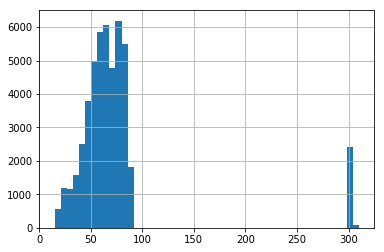

In [17]:
oasis.age.hist(bins=50)

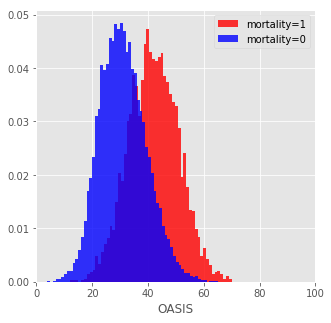

In [117]:
f, axs = plt.subplots(1,1,figsize=(5,5))

plt.hist(oasis.loc[oasis.icustay_expire_flag == 1].oasis,density=1,color='red',label='mortality=1',bins=57,alpha=0.8)
plt.hist(oasis.loc[oasis.icustay_expire_flag == 0].oasis,density=1,color='blue',label='mortality=0',bins=63,alpha=0.8)
plt.legend(loc='best')
plt.xlim(0,100)
plt.xlabel('OASIS')

plt.savefig('oasis.pdf')

(0, 100)

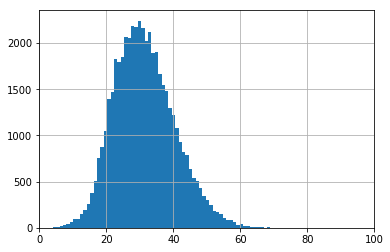

In [19]:
oasis.oasis.hist(bins=65)
plt.xlim(0, 100)

Text(0, 0.5, 'Count')

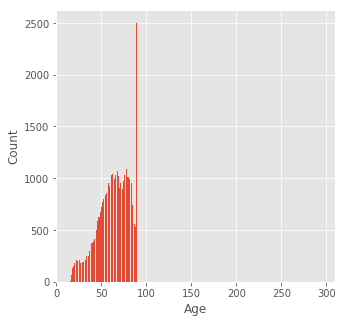

In [78]:
#oasis.loc[oasis.age > 299, 'age'] = 89
plt.style.use('ggplot')
f, axs = plt.subplots(1,1,figsize=(5,5))
plt.hist(oasis.age, bins=97)
plt.xlim(0,310)
plt.xlabel('Age')
plt.ylabel('Count')

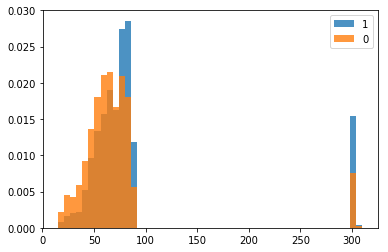

In [20]:
plt.hist(oasis.loc[oasis.hospital_expire_flag == 1].age,density=1,label='1',bins=50,alpha=0.8)
plt.hist(oasis.loc[oasis.hospital_expire_flag == 0].age,density=1,label='0',bins=50,alpha=0.8)
plt.legend(loc='best')
#plt.xlim(0,100)

In [24]:
#X = oasis_adults.drop(['subject_id', 'hadm_id', 'icustay_id', 'icustay_age_group', 'hospital_expire_flag',
#                       'icustay_expire_flag', 'oasis', 'oasis_prob', 'age_prob'], axis=1)
num_features = ['age', 'preiculos_hours', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp', 'urineoutput']
cat_features = ['mechvent', 'electivesurgery']
X = oasis[num_features + cat_features + ['oasis_prob']]
#y = oasis.icustay_expire_flag
y = oasis.hospital_expire_flag
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.25, \
                                                    shuffle=True, stratify=y, random_state=rnd_state)
oasis_prob_test = X_test_orig['oasis_prob']
X_train_orig = X_train_orig.drop(['oasis_prob'],axis=1)
X_test_orig = X_test_orig.drop(['oasis_prob'],axis=1)

In [25]:
print('Shape of training set: {}'.format(X_train_orig.shape))
print('Shape of test set: {}'.format(X_test_orig.shape))
print('Number of positives in training set: {}'.format(y_train.sum()))
print('Number of positives in test set: {}'.format(y_test.sum()))

Shape of training set: (36372, 10)
Shape of test set: (12125, 10)
Number of positives in training set: 4200
Number of positives in test set: 1400


In [26]:
num_impute = ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
scale = ('scale', MinMaxScaler())
num_transformer = Pipeline([num_impute, scale])

cat_impute = ('cat_impute', SimpleImputer(strategy='constant', fill_value=2))
#onehot = ('onehot', OneHotEncoder(handle_unknown='error'))
cat_transformer = Pipeline(steps=[cat_impute])

preprocessor = ColumnTransformer(transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

X_train = preprocessor.fit_transform(X_train_orig)
X_test = preprocessor.transform(X_test_orig)

In [27]:
knc = KNeighborsClassifier(3)
lr = LogisticRegression(random_state=rnd_state,solver='lbfgs',max_iter=1000,class_weight='balanced',C=1.0,tol=0.0001)
svc = LinearSVC(random_state=rnd_state,C=0.025,class_weight='balanced',max_iter=10000)
rbf_svc = SVC(gamma=2, C=1)
rfc = RandomForestClassifier(random_state=rnd_state,n_estimators=100)
abc = AdaBoostClassifier(random_state=rnd_state)
gbc = GradientBoostingClassifier(random_state=rnd_state)

for clf, name in [(lr, 'Logistic'),
                  (rfc, 'RandomForest'),
                  (gbc, 'Gradient Boosting Classifier')][0:1]:
    if name == 'Logistic' or name == 'K Neighbors':    
        clf.fit(X_train, y_train)
    else:
        clf.fit(X_train, y_train,sample_weight=compute_sample_weight(class_weight='balanced', y=y_train))
    predictions = clf.predict(X_test)
    F1 = f1_score(y_test, predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
    print(name)
    print(res)

Logistic
TEST SET f1: 0.35 auroc: 0.70 precision: 0.24 recall: 0.71


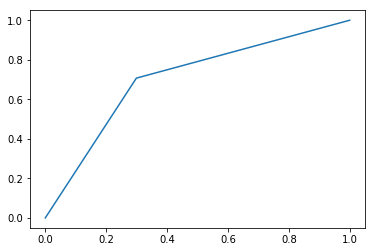

In [28]:
a,b,c = roc_curve(y_test, predictions)
plt.plot(a,b)

In [29]:
logit = np.dot(clf.coef_,X_test.T)
probabilities = np.exp(logit)/(1.+np.exp(logit))

(array([1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        5.000e+00, 6.000e+00, 1.500e+01, 2.900e+01, 5.000e+01, 6.900e+01,
        9.100e+01, 1.000e+02, 1.240e+02, 1.810e+02, 2.410e+02, 3.950e+02,
        5.080e+02, 6.650e+02, 8.670e+02, 9.010e+02, 9.900e+02, 1.024e+03,
        9.520e+02, 8.350e+02, 8.550e+02, 7.160e+02, 6.730e+02, 5.160e+02,
        4.120e+02, 2.670e+02, 1.820e+02, 1.680e+02, 1.180e+02, 6.800e+01,
        3.000e+01, 2.000e+01, 1.500e+01, 1.600e+01, 5.000e+00, 5.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-6.43700240e+00, -6.20725369e+00, -5.97750499e+00, -5.74775629e+00,
        -5.51800759e+00, -5.28825888e+00, -5.05851018e+00, -4.82876148e+00,
        -4.59901277e+00, -4.36926407e+00, -4.13951537e+00, -3.90976667e+00,
        -3.68001796e+00, -3.45026926e+00, -3.22052056e+00, -2.99077186e+00,
        -2.76102315e+00, -2.53127445e+00, -2.30152575e+00, -2.07177704e+

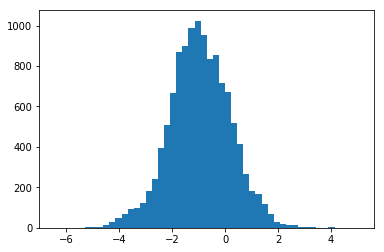

In [30]:
plt.hist(logit[0],bins=50)

(array([133., 277., 296., 378., 475., 494., 549., 571., 550., 513., 507.,
        490., 480., 444., 398., 383., 380., 299., 320., 305., 309., 296.,
        243., 268., 249., 242., 225., 227., 201., 179., 177., 176., 137.,
        132., 107.,  92.,  79.,  79.,  82.,  87.,  80.,  56.,  56.,  18.,
         29.,  14.,  19.,  13.,   8.,   3.]),
 array([0.00159864, 0.02143935, 0.04128006, 0.06112077, 0.08096149,
        0.1008022 , 0.12064291, 0.14048362, 0.16032433, 0.18016504,
        0.20000576, 0.21984647, 0.23968718, 0.25952789, 0.2793686 ,
        0.29920931, 0.31905003, 0.33889074, 0.35873145, 0.37857216,
        0.39841287, 0.41825358, 0.4380943 , 0.45793501, 0.47777572,
        0.49761643, 0.51745714, 0.53729785, 0.55713857, 0.57697928,
        0.59681999, 0.6166607 , 0.63650141, 0.65634212, 0.67618284,
        0.69602355, 0.71586426, 0.73570497, 0.75554568, 0.77538639,
        0.79522711, 0.81506782, 0.83490853, 0.85474924, 0.87458995,
        0.89443066, 0.91427138, 0.93411209, 0.

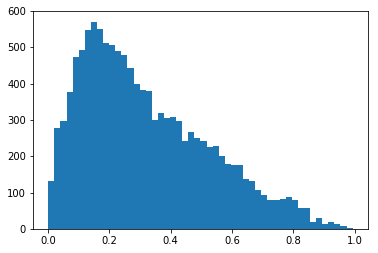

In [31]:
plt.hist(probabilities[0],bins=50)

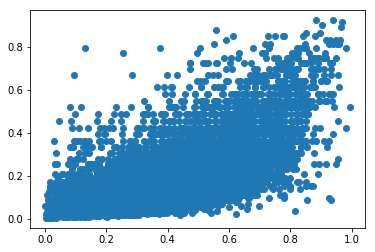

In [32]:
plt.plot(probabilities[0], oasis_prob_test, 'o')

(array([12841., 10724.,  8202.,  5114.,  2784.,  2304.,   925.,  1602.,
         1178.,   503.,   777.,   296.,   436.,   172.,   252.,   172.,
           94.,    56.,    49.,    16.]),
 array([0.00345456, 0.05027863, 0.0971027 , 0.14392677, 0.19075083,
        0.2375749 , 0.28439897, 0.33122304, 0.37804711, 0.42487118,
        0.47169525, 0.51851932, 0.56534339, 0.61216745, 0.65899152,
        0.70581559, 0.75263966, 0.79946373, 0.8462878 , 0.89311187,
        0.93993594]),
 <a list of 20 Patch objects>)

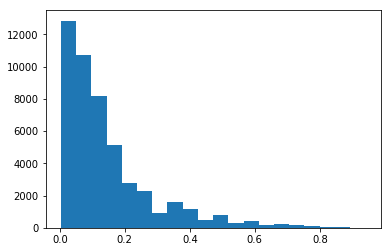

In [33]:
plt.hist(oasis.oasis_prob,bins=20)

In [34]:
auroc = roc_auc_score(y_test, probabilities[0])
auroc

0.7743511821511821

In [35]:
auroc = roc_auc_score(y_test, oasis_prob_test)
auroc

0.7924643023643023

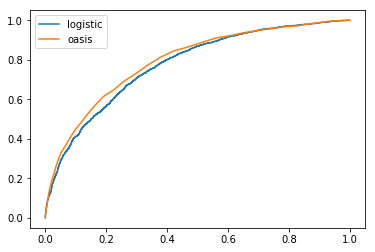

In [36]:
a,b,c = roc_curve(y_test, probabilities[0])
plt.plot(a,b,label='logistic')
a,b,c = roc_curve(y_test, oasis_prob_test)
plt.plot(a,b,label='oasis')
plt.legend(loc='best')

Text(0, 0.5, 'Feature Importance Score')

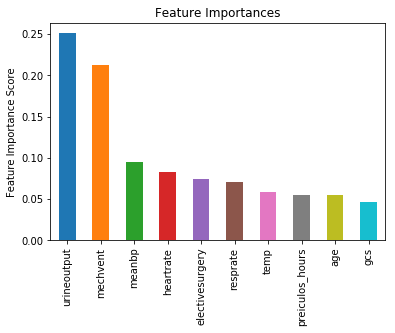

In [32]:
features = num_features + cat_features
feat_imp = pd.Series(clf.feature_importances_, features).sort_values(ascending=False)
feat_imp.iloc[0:30].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [94]:
predictions.sum()

3004

In [93]:
oasis.icustay_expire_flag.value_counts()

0    44636
1     3861
Name: icustay_expire_flag, dtype: int64

In [37]:
oasis_predictions = oasis.oasis_prob.values
oasis_binary_predictions = oasis.oasis_prob.round().values
y_full = oasis.hospital_expire_flag.values
F1 = f1_score(y_full, oasis_binary_predictions)
auroc = roc_auc_score(y_full, oasis_predictions)
precision = precision_score(y_full, oasis_binary_predictions)
recall = recall_score(y_full, oasis_binary_predictions)
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.28 auroc: 0.79 precision: 0.55 recall: 0.18


In [108]:
auroc = roc_auc_score(y_full, oasis.oasis_prob.values)
auroc

0.7907149725755048

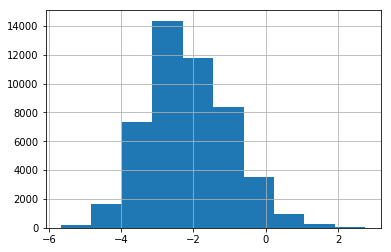

In [100]:
logit = -6.1746 + 0.1275 * oasis.oasis
logit.hist()

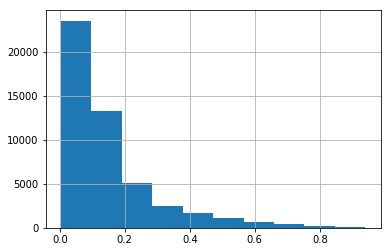

In [101]:
oasis.oasis_prob.hist()

In [92]:
oasis_predictions = np.random.randint(0,2,len(y_full))
oasis_predictions = [1]*len(y_full)
y_full = oasis.icustay_expire_flag.values
F1 = f1_score(y_full, oasis_predictions)
auroc = roc_auc_score(y_full, oasis_predictions)
precision = precision_score(y_full, oasis_predictions)
recall = recall_score(y_full, oasis_predictions)
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.15 auroc: 0.50 precision: 0.08 recall: 1.00


<module 'matplotlib.pyplot' from '/Users/maxim/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

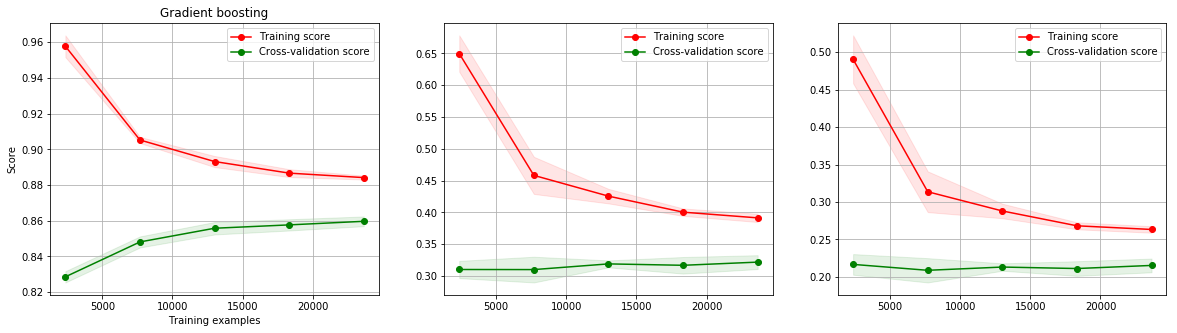

In [90]:
sss = StratifiedShuffleSplit(5, test_size=0.35, random_state=rnd_state)
plot_learning_curve(clf, 'Gradient boosting', X_train, y_train, cv=sss, n_jobs=3)

In [89]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
    

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    # Plot learning curve
    axes[1].grid()
    axes[1].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[1].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[1].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[1].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[1].legend(loc="best")

        

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring='recall')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes[2].grid()
    axes[2].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[2].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[2].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[2].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[2].legend(loc="best")


    return plt

In [54]:
oasis.loc[(oasis.subject_id  == 6702)]

,subject_id,hadm_id,icustay_id,icustay_age_group,hospital_expire_flag,icustay_expire_flag,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heartrate_score,meanbp,meanbp_score,resprate,resprate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score,preiculos_hours
16400,6702,157559,226587,adult,1,0,21,0.029395,80.0,9,28 days 06:54:01,2,11.0,4.0,95.0,1.0,57.000000,2.0,25.0,1.0,37.388891,2.0,2872.0,0.0,0,0,1,0,678.900278
60514,6702,155548,298291,adult,0,0,27,0.061106,76.0,6,0 days 00:01:56,5,15.0,0.0,119.0,3.0,43.333302,3.0,24.0,1.0,36.166666,2.0,1830.0,1.0,0,0,0,6,0.032222


In [51]:
oasis.head()

,subject_id,hadm_id,icustay_id,icustay_age_group,hospital_expire_flag,icustay_expire_flag,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heartrate_score,meanbp,meanbp_score,resprate,resprate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score,preiculos_hours
0,55973,152234,200001,adult,0,0,42,0.305849,61.0,6,7 days 03:02:12,1,14.0,3.0,134.0,6.0,60.000000,2.0,32.0,6.0,36.388889,2.0,250.0,10.0,0,0,0,6,171.036667
1,27513,163557,200003,adult,0,0,35,0.152892,48.0,3,0 days 02:48:04,3,15.0,0.0,122.0,3.0,179.000000,3.0,39.0,6.0,36.388889,2.0,3652.0,0.0,1,9,0,6,2.801111
2,10950,189514,200006,adult,0,0,32,0.109623,54.0,6,0 days 00:01:14,5,15.0,0.0,73.0,0.0,61.000000,2.0,27.0,1.0,36.166666,2.0,1955.0,1.0,1,9,0,6,0.020556
3,20707,129310,200007,adult,0,0,26,0.054187,43.0,3,0 days 00:01:37,5,15.0,0.0,104.0,1.0,50.666698,3.0,29.0,1.0,36.388889,2.0,1295.0,5.0,0,0,0,6,0.026944
4,29904,129607,200009,adult,0,0,25,0.048012,47.0,3,-1 days +23:49:32,5,15.0,0.0,106.0,1.0,60.000000,2.0,17.5,0.0,34.599998,4.0,1570.0,1.0,1,9,1,0,-0.174444


In [53]:
oasis.subject_id.value_counts()

109      34
11861    31
13033    29
5060     27
7809     23
20643    20
73713    18
19059    17
19213    17
11318    17
29035    16
25256    15
22933    15
76327    15
23707    14
5727     14
10635    14
3100     14
21514    13
27800    13
31260    13
41976    13
4787     13
18673    12
15472    12
3977     11
11236    11
94597    11
19246    11
16976    11
         ..
11444     1
5299      1
91913     1
3248      1
58144     1
29823     1
40066     1
44164     1
6943      1
68244     1
56458     1
10132     1
1169      1
424       1
11412     1
15510     1
68381     1
19608     1
17561     1
21659     1
27804     1
15131     1
31902     1
89870     1
14985     1
11033     1
87823     1
58541     1
62639     1
2047      1
Name: subject_id, Length: 37017, dtype: int64